# Install Libraries

In [26]:
!pip install pillow

# Download Dataset

In [27]:
DATASET_DIR = "scalene_triangle_0_355_step5"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/scalene_triangle_0_355_step5.zip > "scalene_triangle_0_355_step5.zip"
!unzip -d "$DATASET_DIR" "scalene_triangle_0_355_step5.zip" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   170  100   170    0     0    429      0 --:--:-- --:--:-- --:--:--   429
100  281k  100  281k    0     0   319k      0 --:--:-- --:--:-- --:--:-- 1008k


# Define Helper Functions

In [28]:
def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

# Load and Pre-Process Training Data

Dataset contains 72 images
Image shape is (50, 50, 1)
x will have shape (72, 50, 50, 1)
y will have shape (72, 3, 2)
Processing image files...


  0%|          | 0/72 [00:00<?, ?it/s]

Selecting test data...


  0%|          | 0/14 [00:00<?, ?it/s]

x_data has shape (58, 50, 50, 1)
y_data has shape (58, 3, 2)
x_test has shape (14, 50, 50, 1)
y_test has shape (14, 3, 2)
x_data values range from 0.0 to 0.8509804010391235
[[-0.25881904 -0.9659258 ]
 [ 0.9659258  -0.25881904]
 [ 0.          0.        ]]


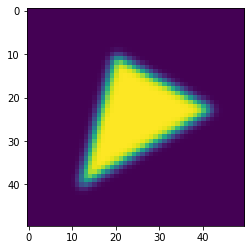

In [186]:
import os
import random
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image, ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

random.seed(0)

D6_SHAPE = (3, 2)
RESIZE_SHAPE = (50, 50)

GAUSS_RADIUS = 1
image_filter = ImageFilter.GaussianBlur(radius=GAUSS_RADIUS)

image_files = os.listdir(DATASET_DIR)
total_images = len(image_files)
print(f"Dataset contains {total_images} images")
if total_images == 0:
  raise ValueError("dataset has no images")

# image_shape = Image.open(os.path.join(DATASET_DIR, image_files[0])).size
image_shape = RESIZE_SHAPE + (1,)
print(f"Image shape is {image_shape}")
x_data = np.zeros((total_images,) + image_shape, dtype="float32")
y_data = np.zeros((total_images,) + D6_SHAPE, dtype="float32")
print(f"x will have shape {x_data.shape}")
print(f"y will have shape {y_data.shape}")
print("Processing image files...")
for i, imf in tqdm(enumerate(image_files), total=total_images):
  im = Image.open(os.path.join(DATASET_DIR, imf)).convert("L")
  im = im.resize(RESIZE_SHAPE)
  im = im.filter(image_filter)
  x_data[i,:,:] = np.array(im).reshape(image_shape)/255
  angle = float(os.path.splitext(imf)[0])
  y_data[i,:,:] = from_SO3_to_6D(R.from_euler("zyx", (angle, 0, 0), True).as_matrix())

# take 20% of the images as test data
total_test_images = int(0.2*total_images)
x_test = np.zeros((total_test_images,) + image_shape)
y_test = np.zeros((total_test_images,) + D6_SHAPE)
print("Selecting test data...")
for i in tqdm(range(total_test_images)):
  r = random.randrange(x_data.shape[0])
  x_test[i] = x_data[r]
  x_data = np.delete(x_data, r, 0)
  y_test[i] = y_data[r]
  y_data = np.delete(y_data, r, 0)
print(f"x_data has shape {x_data.shape}")
print(f"y_data has shape {y_data.shape}")
print(f"x_test has shape {x_test.shape}")
print(f"y_test has shape {y_test.shape}")

print(f"x_data values range from {np.min(x_data)} to {np.max(x_data)}")

plt.imshow(x_data[0,:,:].reshape(RESIZE_SHAPE))
print(y_data[0,:,:])

# Construct Network

In [187]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 5
epochs = 60

model = keras.Sequential([
                          layers.InputLayer(input_shape=image_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
])
model.summary()
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_136 (Dense)            (None, 64)                247872    
_________________________________________________________________
dense_137 (Dense)            (None, 128)             

# Train Model

Epoch 1/60
12/12 [==============================] - 1s 17ms/step - loss: 0.3400 - accuracy: 0.6552
Epoch 2/60
12/12 [==============================] - 0s 19ms/step - loss: 0.3308 - accuracy: 0.6437
Epoch 3/60
12/12 [==============================] - 0s 17ms/step - loss: 0.3255 - accuracy: 0.6897
Epoch 4/60
12/12 [==============================] - 0s 18ms/step - loss: 0.3221 - accuracy: 0.6034
Epoch 5/60
12/12 [==============================] - 0s 18ms/step - loss: 0.3191 - accuracy: 0.6609
Epoch 6/60
12/12 [==============================] - 0s 17ms/step - loss: 0.3158 - accuracy: 0.6437
Epoch 7/60
12/12 [==============================] - 0s 17ms/step - loss: 0.3129 - accuracy: 0.5862
Epoch 8/60
12/12 [==============================] - 0s 17ms/step - loss: 0.3084 - accuracy: 0.6724
Epoch 9/60
12/12 [==============================] - 0s 18ms/step - loss: 0.3058 - accuracy: 0.6264
Epoch 10/60
12/12 [==============================] - 0s 17ms/step - loss: 0.3023 - accuracy: 0.6092
Epoch 11/

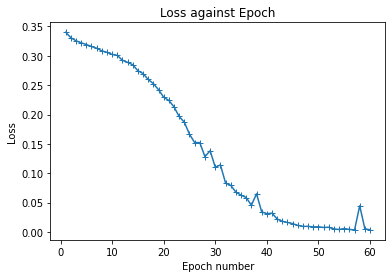

In [188]:
history = model.fit(
    x_data,
    y_data,
    batch_size,
    epochs,
)
plt.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Loss against Epoch")
plt.show()

# Test Model

In [189]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.00371945439837873
Test accuracy: 0.8571428656578064


In [191]:
i = 1
print("True SO(3):\n", from_6D_to_SO3(y_test[i].astype("float32")), end="\n\n", sep="")
print("True 6D:\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("6D Prediction:\n", prediction, end="\n\n", sep="")
print("SO(3) Prediction:\n", from_6D_to_SO3(prediction), sep="")

True SO(3):
[[-0.64278764 -0.76604444  0.        ]
 [ 0.76604444 -0.64278764  0.        ]
 [ 0.          0.          1.        ]]

True 6D:
[[-0.64278764 -0.76604444]
 [ 0.76604444 -0.64278764]
 [ 0.          0.        ]]

6D Prediction:
[[-0.63678575 -0.73580945]
 [ 0.7329963  -0.6973072 ]
 [-0.0187593   0.04538656]]

SO(3) Prediction:
[[-0.655703   -0.7547404   0.02050471]
 [ 0.7547717  -0.65455186  0.04337648]
 [-0.01931659  0.04391846  0.9988483 ]]
